## Detecção de obstrução em válvulas de máquinas de LC por análise de séries temporais
### IFES - PPCOMP - Mestrado em Computação Aplicada

**Notebook**: Seleção de características e Clusterização v0.3

Periodo preliminar de análise: 01/2019 e 02/2019 (2 meses)
*****
**Datasets** (40+ Séries Temporais em intervalos de 10/10 segundos)

**Fonte:** Notebook - featureExtraction-colgging
+ features_Strand3.csv (Caracteristicas extraidas - Veio 3)
*****

Este Notebook busca identificar situações anômalas no comportamento de sinais temporais que foram discretizado em um conjunto de caracteristicas por intermedio de janela deslizante.

A abordagem a ser utilizada para identificação será o uso de uma técnica de aprendizado de máquina não supervisionada, neste caso agrupamento (clustering). 

A proposição foi de realizar uma clusterização multidimensional seguindo as seguintes etapas:
+ Seleção de caracterísitcas: Eliminação de variância '0' e correlação superior a 0.98 entre as dimensões.
+ Limpeza de valores NaN/Inf
+ Normalização dos dados (*StandardScaler*)
+ Clusterização utilizando o metodo DBSCAN *(Density Based Spatial Clustering of Applications with Noise)*
+ Alteração do espaço dimensional para visualização dos resultados (TSNE e UMAP)
+ Separação dos outliers (cluster label = -1) e realização de nova clusterização no espaço spectral
+ Identificação das regiões anômalas: Obustrução (*'Clogging'*), retorno e saída de processo, troca de válvulas.

**Observacao:** A distância de Mahalanobis foi aplicada no processo de separacao dos clusters e se mostrou mais efetiva na caracterizacao dos *Outliers*

Como resultado deste trabalho pretend-se utilizar os resultados produzidos pela tecnica para gerar o *labeling* de uma base de dados de processo, onde espera-se na sequencia produzir um modelo classificador eficiente para identificacao das obstrucoes.

In [2]:
# Bibliotecas Python em uso no projeto

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler,RobustScaler,Normalizer,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import silhouette_samples, silhouette_score as sc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ParameterGrid


#from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP as UMAP

import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Standard plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=False)
import plotly.graph_objects as go

### Análise do Veio 3

**Observação:** Processo análogo será realizado sobre o Dataset do **Veio 4** objetvando complementar a identificação de todas as características.

In [3]:
# Leitura do dataset gerado.
df1=pd.read_csv('./data/features_Strand3_new.csv',index_col=0)
df1.shape

(13623, 24)

**Seleção de caracterísitcas**

+ Eliminação de variância '0'
+ correlação superior a 0.98 entre as dimensões (*Features* extraídas)

In [4]:
df1=df1.loc[:, df1.var() != 0.0]
df1.shape

(13623, 24)

In [5]:
# Matriz de correlacao
corr_matrix = df1.corr().abs()
# Selecciona o triangulo superior da matriz de correlacao
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Encontra features com correlação > 0.98
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
# Elimina features 
df1_1=df1.drop(labels=to_drop, axis=1)
df1_1.shape

(13623, 22)

##### Eliminação de valores NaN / Infinity

In [6]:
# Eliminacao das caracteristicas (colunas) com valores NaN / Infinito
df1_2=df1_1.copy(deep=True)
df1_2.replace([np.inf, -np.inf], np.nan)
df1_2.dropna(axis=1, how='any',inplace=True)
df1_2.shape

(13623, 22)

In [7]:
# Preenchimento dos NaN em linhas com o valor medio das colunas
df1_2 = df1_2.fillna(df1_2.mean())
df1_2.shape

(13623, 22)

In [8]:
df1_2.head()

LC2.K_SLDGT_STR3A_AL_POS__absolute_sum_of_changes  \
id                                                           
5154336                                            23.9157   
5154337                                            27.3841   
5154338                                            30.9593   
5154339                                            24.0946   
5154340                                            27.7816   

         LC2.K_SLDGT_STR3A_AL_POS__large_standard_deviation__r_0.5  \
id                                                                   
5154336                                                0.0           
5154337                                                0.0           
5154338                                                0.0           
5154339                                                0.0           
5154340                                                0.0           

         LC2.K_SLDGT_STR3A_AL_POS__linear_trend__attr_"slope"  \
id                                                              
5154336                                          -0.026096      
5154337                                           0.016003      
5154338                                           0.010740      
5154339                                           0.002156      
5154340                                          -0.024659      

         LC2.K_SLDGT_STR3A_AL_POS__longest_strike_above_mean  \
id                                                             
5154336                                                8.0     
5154337                                                3.0     
5154338                                                3.0     
5154339                                                5.0     
5154340                                                3.0     

         LC2.K_SLDGT_STR3A_AL_POS__longest_strike_below_mean  \
id                                                             
5154336                                                5.0     
5154337                                                3.0     
5154338                                                5.0     
5154339                                                5.0     
5154340                                                3.0     

         LC2.K_SLDGT_STR3A_AL_POS__maximum  LC2.K_SLDGT_STR3A_AL_POS__mean  \
id                                                                           
5154336                            42.7774                       41.278540   
5154337                            42.8745                       41.138870   
5154338                            43.4559                       41.836457   
5154339                            43.0716                       41.868233   
5154340                            43.1000                       41.123410   

         LC2.K_SLDGT_STR3A_AL_POS__mean_change  \
id                                               
5154336                              -0.041162   
5154337                               0.011548   
5154338                               0.011948   
5154339                               0.065055   
5154340                               0.014083   

         LC2.K_SLDGT_STR3A_AL_POS__mean_second_derivative_central  \
id                                                                  
5154336                                           0.009763          
5154337                                          -0.032738          
5154338                                          -0.003943          
5154339                                          -0.011734          
5154340                                          -0.009661          

         LC2.K_SLDGT_STR3A_AL_POS__median  ...  \
id                                         ...   
5154336                          41.26390  ...   
5154337                          41.10845  ...   
5154338                          41.83035  ...   
5154339                          41.96130  ...   
5154340                          40.99510  ... 

##### Alteração de Escala
[Standard Scaler](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02)

In [9]:
# Alteracap de escala
scaler=StandardScaler()
df1_s=pd.DataFrame(scaler.fit_transform(df1_2),index=df1_2.index,columns=df1_2.columns)

##### PCA

Aplicação do PCA com 98% de explicação da variância em caráter exploratório. Esta redução dimensional não foi satisfatória no processo de clusterização e com isto foi descartada.

In [9]:
pca = PCA(n_components=0.98)
df1_pca=pca.fit_transform(df1_s)
df1_pca=pd.DataFrame(df1_pca,index=df1_s.index)
df1_pca.shape

(7049, 15)

### Redução de Dimensionalidade - Visualização dos Resultados
Aplicação de técnicas de redução de dimensionalidade **[t-SNE](https://lvdmaaten.github.io/tsne/) e [UMAP](https://umap-learn.readthedocs.io/en/latest/)** com o objetivo de visualizar o resultado da clusterização.
>t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets

>Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction

In [10]:
tsne = TSNE(n_components=2,n_jobs=-1,perplexity=30,n_iter=1500)
tsne_results = tsne.fit_transform(df1_s)

In [10]:
umap = UMAP(n_components=2)
umap_results = umap.fit_transform(df1_s)

#### Clusterização - DBSCAN
Aplicação do algoritmo de clusterização **DBSCAN** *(Density Based Spatial Clustering of Applications with Noise)*
Os hyper-parâmetros foram estressados em análise exploratória, com os valores de *epsilon* e *minpoints* devidamente ajustados.

Dois clusters foram gerados utilizando a distância euclidiana e a distância de **Mahalanobis** sendo que a última se mostrou mais efetiva na separação dos *outliers*.
$$
D_{M}(\vec{x},\vec{y})=(  (\vec{x} - \vec{y})' {\rm \bf C}^{-1} (\vec{x} - \vec{y}) )^{\frac{1}{2}}
$$


In [11]:
dbs = DBSCAN(eps=5, min_samples=50, metric='mahalanobis', 
                       algorithm='brute', n_jobs=-1)

In [12]:
# Variações de hyper-parâmetros e testes com PCA
#clustering = DBSCAN(eps=2.1, min_samples=50,n_jobs=-1).fit(df1_s)
#clustering = DBSCAN(eps=7, min_samples=20,n_jobs=-1).fit(df1_s)
#clustering_pca = DBSCAN(eps=2.05, min_samples=50,n_jobs=-1).fit(df1_pca)

# clusterização com Distância Euclidiana
clustering = DBSCAN(eps=5, min_samples=50,n_jobs=-1).fit(df1_s)

# clusterização com Distância de Mahalanobis
clustering_mah = dbs.fit(df1_s)

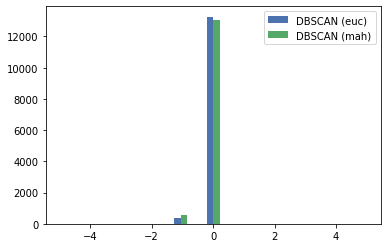

In [13]:
plt.style.use('seaborn-deep')

bins = np.linspace(-5, 5, 20)
plt.hist([clustering.labels_, clustering_mah.labels_], bins, label=['DBSCAN (euc)', 'DBSCAN (mah)'])
plt.legend(loc='upper right')
plt.show()

In [14]:
np.unique(clustering.labels_)

array([-1,  0], dtype=int64)

In [15]:
np.unique(clustering_mah.labels_)

array([-1,  0], dtype=int64)

| Cluster Label | Descrição |
| ------ | ------ |
| -1 |*Outiers* | 
| 0 | Norma|

### Visualização dos Resultados (UMAP)

In [16]:
df_umap=pd.DataFrame()
df_umap['umap-one']=umap_results[:,0]
df_umap['umap-two']=umap_results[:,1]
df_umap['clusters_euc']=clustering.labels_
df_umap['clusters_mah']=clustering_mah.labels_

**Visualização UMAP**
+ Método de clusterização: DBSCAN
+ Distância: Euclidiana

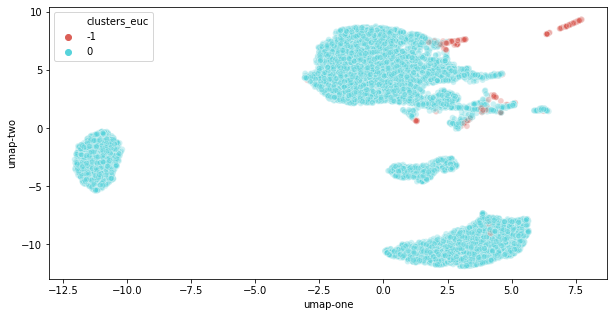

In [25]:
# Visualização Matplotlib
# plt.figure(figsize=(15,5))
# void=plt.scatter(umap_results[:,0],umap_results[:,1],c=clustering.labels_,alpha=1)

#Visualização Seaborn
plt.figure(figsize=(10,5))
void=sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="clusters_euc",
    palette=sns.color_palette("hls", len(np.unique(clustering.labels_))),
    data=df_umap,
    legend="full",
    alpha=0.3
)

**Visualização UMAP**
+ Método de clusterização: DBSCAN
+ Distância: **Mahalanobis**

Verifica-se a identificação de um número maior de outliers (-1)

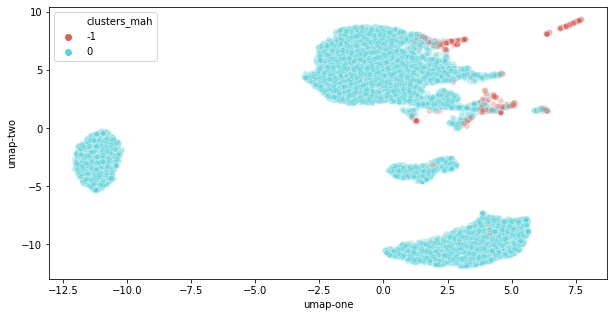

In [18]:
# Visualização Matplotlib
# plt.figure(figsize=(15,7))
# void=plt.scatter(umap_results[:,0],umap_results[:,1],c=clustering_mah.labels_)

#Visualização Seaborn
plt.figure(figsize=(10,5))
void=sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="clusters_mah",
    palette=sns.color_palette("hls", len(np.unique(clustering_mah.labels_))),
    data=df_umap,
    legend="full",
    alpha=0.3
)


### Visualização dos Resultados (t-SNE)

In [23]:
df_tsne=pd.DataFrame()
df_tsne['tsne-one']=tsne_results[:,0]
df_tsne['tsne-two']=tsne_results[:,1]
df_tsne['clusters_euc']=clustering.labels_
df_tsne['clusters_mah']=clustering_mah.labels_

**Visualização t-SNE**
+ Método de clusterização: DBSCAN
+ Distância: Euclidiana

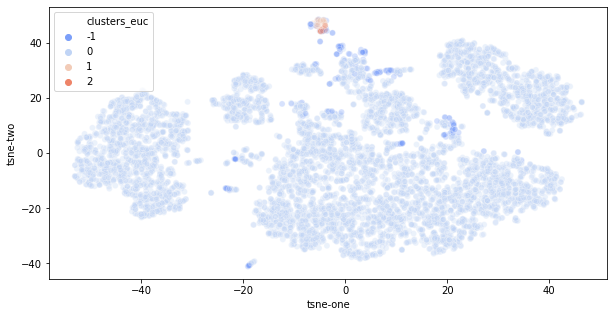

In [24]:
# Visualização Matplotlib
# plt.figure(figsize=(30,16))
# plt.scatter(tsne_results[:,0],tsne_results[:,1],c=clustering.labels_)

#Visualização Seaborn
plt.figure(figsize=(10,5))
void=sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="clusters_euc",
    palette=sns.color_palette("coolwarm", 4),
    data=df_tsne,
    legend="full",
    alpha=0.3
)

**Visualização t-SNE**
+ Método de clusterização: DBSCAN
+ Distância: **Mahalanobis**

Verifica-se a identificação de um número maior de outliers (-1)

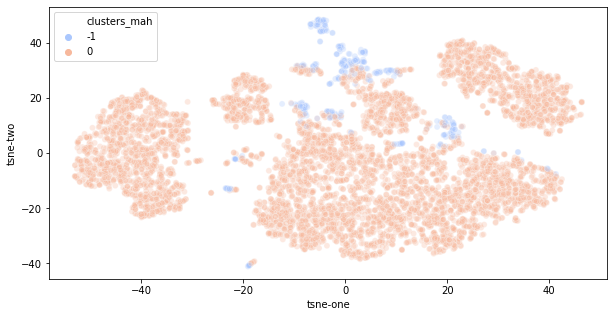

In [26]:
plt.figure(figsize=(10,5))
void=sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="clusters_mah",
    palette=sns.color_palette("coolwarm", 2),
    data=df_tsne,
    legend="full",
    alpha=0.3
)

##### Navegação Iterativa (UMAP )

+ Método de clusterização: DBSCAN
+ Distância: **Mahalanobis**

Identificação das janelas deslizantes do dataframe original ('**id**'), possibilitando conferência dos resultados gerados.

In [26]:
fig = go.Figure(data=go.Scatter(
    x = umap_results[:,0],
    y = umap_results[:,1],
    opacity=0.6,
    mode='markers',
    marker=dict(color=clustering_mah.labels_,
                size=5)
    ,text = list(zip(df1_s.index,clustering_mah.labels_))
))
fig.show()

##### Comparativo entre os Clusters de Anomalias (-1) 
**cl_e** = Anomalias detecadas por distância euclidiana

**cl_mah** = Anomalias detecadas por distância de Mahalanobis

In [27]:
cl_e=(clustering.labels_== -1) | (clustering.labels_== 1) | (clustering.labels_== 2)
cl_mah=clustering_mah.labels_== -1

In [28]:
# Total de Anomalias - Distância euclidiana
df1_s.loc[cl_e].shape

(356, 22)

In [29]:
# Total de Anomalias - Distância de Mahalanobis
df1_s.loc[cl_mah].shape

(581, 22)

In [30]:
# Elementos adicionais identificados com distância de Mahalanobis não presentes 
# no cluster gerado com distância euclidiana
df1_s.loc[cl_mah&(~cl_e)].shape

(226, 22)

In [31]:
# Elementos adicionais identificados com distância de euclidiana não presentes 
# no cluster gerado com distância de mahalanobis
df1_s.loc[cl_e&(~cl_mah)].shape

(1, 22)

##### Avaliação se determinado indice de janela está incluso no conjunto de anomalias

In [32]:
isAnomaly=df1_s.index==5171277
df1_s.loc[cl_mah & isAnomaly]

LC2.K_SLDGT_STR3A_AL_POS__absolute_sum_of_changes  \
id                                                           
5171277                                           4.931324   

         LC2.K_SLDGT_STR3A_AL_POS__large_standard_deviation__r_0.5  \
id                                                                   
5171277                                          -0.008568           

         LC2.K_SLDGT_STR3A_AL_POS__linear_trend__attr_"slope"  \
id                                                              
5171277                                           4.967184      

         LC2.K_SLDGT_STR3A_AL_POS__longest_strike_above_mean  \
id                                                             
5171277                                          -0.084132     

         LC2.K_SLDGT_STR3A_AL_POS__longest_strike_below_mean  \
id                                                             
5171277                                           1.188883     

         LC2.K_SLDGT_STR3A_AL_POS__maximum  LC2.K_SLDGT_STR3A_AL_POS__mean  \
id                                                                           
5171277                           5.882092                        4.476424   

         LC2.K_SLDGT_STR3A_AL_POS__mean_change  \
id                                               
5171277                               1.753381   

         LC2.K_SLDGT_STR3A_AL_POS__mean_second_derivative_central  \
id                                                                  
5171277                                          -6.428434          

         LC2.K_SLDGT_STR3A_AL_POS__median  ...  \
id                                         ...   
5171277                          3.857115  ...   

         LC2.K_SLDGT_STR3A_AL_POS__variance  \
id                                            
5171277                            4.646937   

         LC2.K_SLDGT_STR3A_AL_POS__variance_larger_than_standard_deviation  \
id                                                                           
5171277                                           0.791475                   

         LC2.K_SLDGT_STR3A_AL_POS_diff__count_above_mean  \
id                                                         
5171277                                        -0.703422   

         LC2.K_SLDGT_STR3A_AL_POS_diff__number_crossing_m__m_0  \
id                                                               
5171277                                          -1.145551       

         LC2.K_SLDGT_STR3A_AL_POS_diff__variance_larger_than_standard_deviation  \
id                                                                                
5171277                                           0.660506                        

         LC2.FT_671_3_F__linear_trend__attr_"slope"  \
id                                                    
5171277                                    -0.00135   

         LC2.FT_673_3_F__linear_trend__attr_"slope"  \
id                                                    
5171277                                    0.003771   

         LC2.FT_681_3_F__linear_trend__attr_"slope"  \
id                                                    
5171277                                   -0.026818   

         LC2.FT_683_3_F__linear_trend__attr_"slope"  \
id                                                    
5171277                                    0.260526   

         LC2.K_SLDGT_STR3A_AL_POS__minmax  
id                                         
5171277                          4.367257  

[1 rows x 22 columns]

##### Comparativo do desvio padrão das características extraídas entre norma(0) e outliers(-1)

In [33]:
df_cl = df1_s.copy()
df_cl['cl'] = clustering_mah.labels_
df_cl.groupby(by='cl').describe().T.filter(like='std',axis=0)

cl                                                            -1             0
LC2.K_SLDGT_STR3A_AL_POS__absolute_sum_of_changes  std  2.229132  7.585347e-01
LC2.K_SLDGT_STR3A_AL_POS__large_standard_deviat... std  4.842440  1.630703e-15
LC2.K_SLDGT_STR3A_AL_POS__linear_trend__attr_"s... std  3.665205  6.645339e-01
LC2.K_SLDGT_STR3A_AL_POS__longest_strike_above_... std  1.126204  9.767018e-01
LC2.K_SLDGT_STR3A_AL_POS__longest_strike_below_... std  1.210545  9.474252e-01
LC2.K_SLDGT_STR3A_AL_POS__maximum                  std  2.185806  8.657736e-01
LC2.K_SLDGT_STR3A_AL_POS__mean                     std  1.781875  9.359867e-01
LC2.K_SLDGT_STR3A_AL_POS__mean_change              std  3.480139  7.059480e-01
LC2.K_SLDGT_STR3A_AL_POS__mean_second_derivativ... std  3.610373  6.818291e-01
LC2.K_SLDGT_STR3A_AL_POS__median                   std  1.996507  9.149904e-01
LC2.K_SLDGT_STR3A_AL_POS__minimum                  std  1.517216  8.513110e-01
LC2.K_SLDGT_STR3A_AL_POS__standard_deviation       std  2.096922  5.222754e-01
LC2.K_SLDGT_STR3A_AL_POS__variance                 std  3.122586  2.441237e-01
LC2.K_SLDGT_STR3A_AL_POS__variance_larger_than_... std  0.292512  1.007330e+00
LC2.K_SLDGT_STR3A_AL_POS_diff__count_above_mean    std  2.914436  8.154328e-01
LC2.K_SLDGT_STR3A_AL_POS_diff__number_crossing_... std  1.354900  8.977655e-01
LC2.K_SLDGT_STR3A_AL_POS_diff__variance_larger_... std  0.345152  1.011105e+00
LC2.FT_671_3_F__linear_trend__attr_"slope"         std  4.262305  4.854774e-01
LC2.FT_673_3_F__linear_trend__attr_"slope"         std  4.784502  1.615616e-01
LC2.FT_681_3_F__linear_trend__attr_"slope"         std  4.178738  5.176925e-01
LC2.FT_683_3_F__linear_trend__attr_"slope"         std  4.711893  2.387891e-01
LC2.K_SLDGT_STR3A_AL_POS__minmax                   std  1.960083  5.674821e-01

####  Clusterização - Fase 2 - DBSCAN em Espaço Dimensional Simplificado (UMAP) sobre o conjunto de Anomalias

Aplicação do algoritmo de clusterização **DBSCAN** *(Density Based Spatial Clustering of Applications with Noise)* em um segundo passo envolvendo apenas o conjunto de anomalias previamente identificadas em espaço dimensional UMAP.

Tem-se por objetivo uma caracterização ainda maior dos cenários anômalos no processo (Obstrução, troca de válvula, saída e retorno de processo).


In [34]:
umap = UMAP(n_components=2)
umap_results2 = umap.fit_transform(df1_s[cl_mah])

In [35]:
#clustering2 = DBSCAN(eps=0.5, min_samples=5,n_jobs=-1).fit(umap_results2)

param_grid = {
    'eps':np.arange(0.1, 0.9, 0.1),
    'min_samples':range(3,6,1),
    'n_jobs':[-1]
}

best_score=float(-1.0)
max_clusters=15

for g in ParameterGrid(param_grid):
    ca = DBSCAN( **g )
    ca.fit(umap_results2)
    nclusrers = np.unique(ca.labels_).size
    s_score = sc(umap_results2,ca.labels_)
    print (g,s_score,nclusrers)
    if (s_score > best_score) & (nclusrers<=max_clusters):
        best_score=s_score
        best_grid=g

print ("Best Score: %0.5f" % best_score)
print ("Grid:", best_grid)

clustering2=DBSCAN(**best_grid).fit(umap_results2)

{'eps': 0.1, 'min_samples': 3, 'n_jobs': -1} 0.06842602 57
{'eps': 0.1, 'min_samples': 4, 'n_jobs': -1} -0.12462287 41
{'eps': 0.1, 'min_samples': 5, 'n_jobs': -1} -0.28575236 30
{'eps': 0.2, 'min_samples': 3, 'n_jobs': -1} 0.49009046 52
{'eps': 0.2, 'min_samples': 4, 'n_jobs': -1} 0.40942362 42
{'eps': 0.2, 'min_samples': 5, 'n_jobs': -1} 0.32385477 34
{'eps': 0.30000000000000004, 'min_samples': 3, 'n_jobs': -1} 0.44423276 25
{'eps': 0.30000000000000004, 'min_samples': 4, 'n_jobs': -1} 0.45793548 26
{'eps': 0.30000000000000004, 'min_samples': 5, 'n_jobs': -1} 0.52266175 29
{'eps': 0.4, 'min_samples': 3, 'n_jobs': -1} 0.43161538 19
{'eps': 0.4, 'min_samples': 4, 'n_jobs': -1} 0.4673134 18
{'eps': 0.4, 'min_samples': 5, 'n_jobs': -1} 0.46191284 18
{'eps': 0.5, 'min_samples': 3, 'n_jobs': -1} 0.28572583 13
{'eps': 0.5, 'min_samples': 4, 'n_jobs': -1} 0.3549506 12
{'eps': 0.5, 'min_samples': 5, 'n_jobs': -1} 0.42325675 11
{'eps': 0.6, 'min_samples': 3, 'n_jobs': -1} 0.31461558 11
{'eps': 

In [37]:
pd.unique(clustering2.labels_).size

7

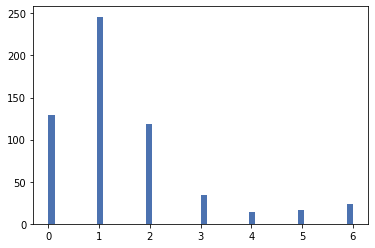

In [38]:
void=plt.hist(clustering2.labels_,bins=50)

In [39]:
np.unique(clustering2.labels_).size

7

In [40]:
df_umap2=pd.DataFrame()
df_umap2['umap-one']=umap_results2[:,0]
df_umap2['umap-two']=umap_results2[:,1]
df_umap2['clusters']=clustering2.labels_

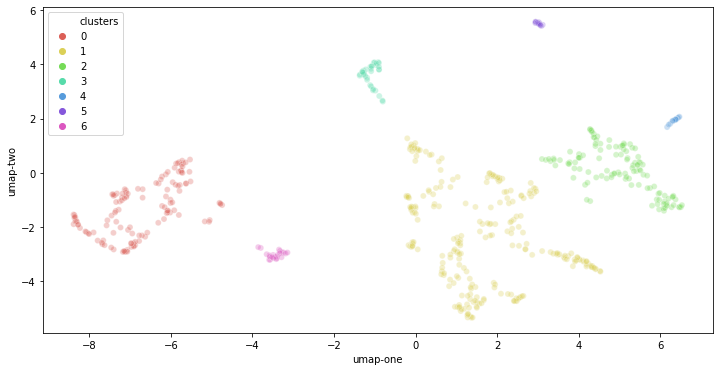

In [41]:
#Visualização Seaborn
plt.figure(figsize=(12,6))
void=sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="clusters",
    palette=sns.color_palette("hls", np.unique(clustering2.labels_).size),
    data=df_umap2,
    legend="full",
    alpha=0.3
)

In [42]:
fig = go.Figure(data=go.Scatter(
    x = umap_results2[:,0],
    y = umap_results2[:,1],
    opacity=0.8,
    mode='markers',
    marker=dict(color=clustering2.labels_,
                size=5)
    ,text = list(zip(df1_s[cl_mah].index,clustering2.labels_))
))
fig.show()

##### Armazena Clusters - Veio3

In [43]:
clv3=pd.DataFrame(index=df1_s[cl_mah].index,columns=['clusters'])
clv3['clusters']=clustering2.labels_
clv3.to_csv('./data/clusters_Strand3_new.csv')